The repo can be requested on https://bam-dataset.org. It contains links to the files, so we will need to download them.

In [7]:
import sqlite3
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BAM_FILE = "./bam-file.sqlite"
conn = sqlite3.connect(BAM_FILE)
curs = conn.cursor()

In [3]:
attributes = ['media_3d_graphics', 'media_comic', 'media_graphite', 'media_oilpaint', 'media_pen_ink', 'media_vectorart', 'media_watercolor']
out_folder = '/disk2/paint/'

In [6]:
import urllib.request
from urllib.error import HTTPError
def saveData(data, name):
    index = 0
    failed = 0
    length = len(data)
    for i in data:
        print('{} from {}, failed {}               '.format(index, length, failed), end='\r')
        link = str(i)[2:-3]
        extension = link.split('.')[-1]
        try:
            urllib.request.urlretrieve(link, out_folder + name + '.' + str(index) + '.' + extension)
        except HTTPError:
            failed+=1
            print(index, 'Image not found. Skipping...', end='\r')
        finally:
            index+=1

In [7]:
for attribute in attributes[1:]:
    cc = conn.execute('select src from modules, crowd_labels where modules.mid = crowd_labels.mid and attribute = "'
                      + str(attribute) + '" and label="positive"')
    data = cc.fetchall()
    print('Fetched', attribute)
    saveData(data, attribute)

Fetched media_comic
Fetched media_graphiteed 725               
Fetched media_oilpaint 467               
Fetched media_pen_inkd 168               
Fetched media_vectorart503               
Fetched media_watercolor77               


Let's see how many images of each class do we have

In [13]:
attr_count =  {k:0 for k in attributes}
for img in tqdm(os.listdir(out_folder)):
    name = img.split('.')[0]
    attr_count[name] += 1
print(attr_count)

100%|██████████| 51019/51019 [00:00<00:00, 1028873.35it/s]

{'media_3d_graphics': 10069, 'media_oilpaint': 3530, 'media_pen_ink': 8389, 'media_vectorart': 4197, 'media_comic': 12472, 'media_watercolor': 5150, 'media_graphite': 7212}


So, let's take 5000 images of each class (media_oilpaint will stay 3530, media_vectorart - 4197, I think it's okay)

In [15]:
# But let's see image sizes firstly
# how big should be our image?
import get_image_size
for img in tqdm(os.listdir(out_folder)):
    name = img.split('.')[0]
    path = os.path.join(out_folder, img)
    try:
        width, height = get_image_size.get_image_size(path)
        print(img, ' [', width, height, ']')
    except get_image_size.UnknownImageFormat:
        print(img, 'unknown format')

  0%|          | 216/51019 [00:00<00:47, 1077.71it/s]

media_watercolor.971.jpg  [ 600 850 ]
media_comic.9765.jpg  [ 504 756 ]
media_oilpaint.2025.jpg  [ 600 450 ]
media_pen_ink.8599.jpg  [ 600 440 ]
media_oilpaint.3256.jpg  [ 600 695 ]
media_graphite.2848.jpg  [ 600 884 ]
media_watercolor.3158.jpg  [ 600 465 ]
media_graphite.2954.jpg  [ 600 813 ]
media_watercolor.4069.jpg  [ 600 688 ]
media_comic.1013.jpg  [ 600 526 ]
media_comic.3426.jpg  [ 600 985 ]
media_watercolor.2333.jpg  [ 600 928 ]
media_pen_ink.1429.jpg  [ 600 539 ]
media_watercolor.5485.png  [ 600 950 ]
...

Let's see some images after resizing, can we still figure out which classes correspond to them?
- 50x50 - not very good
- 100x100 - seeems to be fine  
Maybe, let's choose 112 then?  
https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png

  0%|          | 30/51019 [00:00<27:03, 31.41it/s]


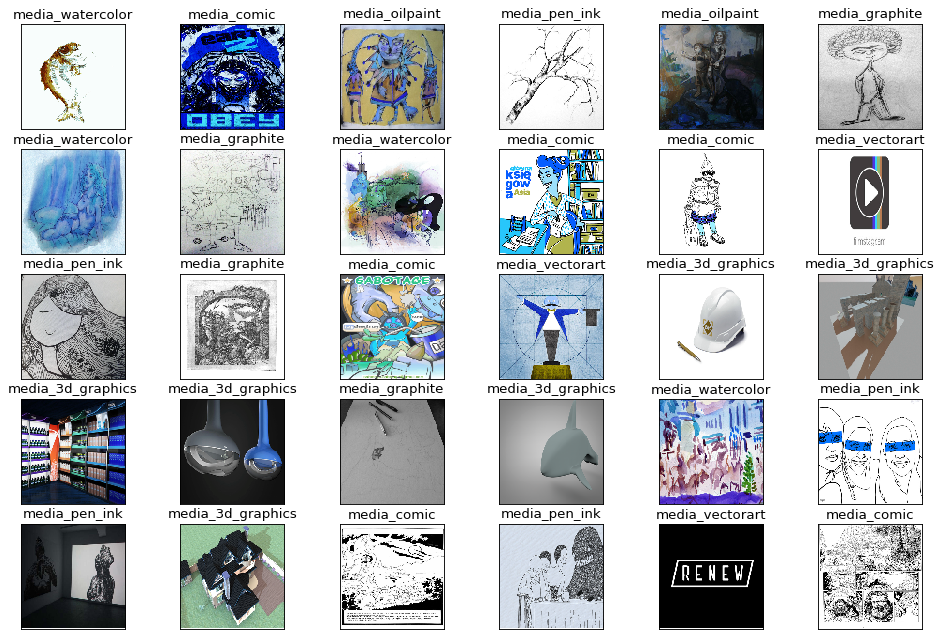

In [11]:
fig = plt.figure(figsize=(15, 10), dpi=80)
IMG_SIZE = 112
rows = 5
cols = 6
num = 1
for img in tqdm(os.listdir(out_folder)):
    name = img.split('.')[0]
    path = os.path.join(out_folder, img)
    image = cv2.imread(path, 1)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
    
    if (num > rows * cols):
        break
    y = fig.add_subplot(rows,cols,num)
    y.imshow(image)
    plt.title(name)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    num+=1
plt.show()